In [3]:
from PPO_train_test import PPO_train, PPO_train_udr, PPO_train_adr, PPO_test

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Hopper Environment

We want to deploy our agent in the real world that is represented by the Target environment, but we have only access to a simulator (source environment) which has a sistematic error wrt real word.

Since we want to close this sim2real gap we will experiment some techniques to address this problem.

To begin with, we will try a simple UDR. Then our focus will be implementing an ADR technique inspired to the OpenAI original paper where ADR is formally introduced in the RL world.

In the following experiment a PPO, policy-based RL algorithm, will be employed.

Nota:
- In Target, l'hopper ha un torso più pesante. La massa elevata conferisce inerzia. L'inerzia agisce come un "filtro passa-basso" naturale: smorza le oscillazioni e rende il robot più stabile contro piccoli errori di controllo o rumore nelle azioni.

- In Source, l'hopper ha un torso molto più leggero. Con meno inerzia, il robot diventa "nervoso" (twitchy). Ogni piccola forza applicata dai motori si traduce in un'accelerazione angolare molto più rapida (F=m⋅a→a=F/m; se m scende, a sale). Questo rende molto più facile per il robot perdere l'equilibrio e cadere (terminando l'episodio prima dei 500 step).

I motori (attuatori) dell'Hopper hanno la stessa forza massima in entrambi gli ambienti, ma nel Source devono spingere meno massa.
Nel caso Source, il robot è "sovra-potenziato" rispetto al suo peso. Questo rende il paesaggio di ottimizzazione (la "superficie" che l'algoritmo PPO deve scalare) molto più frastagliato. Un'azione leggermente sbagliata nel Source porta a conseguenze catastrofiche (caduta) molto più velocemente che nel Target.
L'ambiente Hopper-v* standard di Gym (che corrisponde al tuo Target) è stato progettato e sintonizzato dai creatori di MuJoCo per avere proprietà fisiche che rendono la locomozione apprendibile e stabile. Modificando arbitrariamente una massa fondamentale come quella del torso (togliendo 1kg, che è una percentuale significativa del peso totale), si crea un robot "sbilanciato" o fisicamente meno adatto alla locomozione rispetto al design originale.

In [1]:
TIMESTEPS = 1_000_000
SEED = 11

To begin with, lets train PPO on source and test on source:


--- Training on CustomHopper-source-v0 ---


Output()

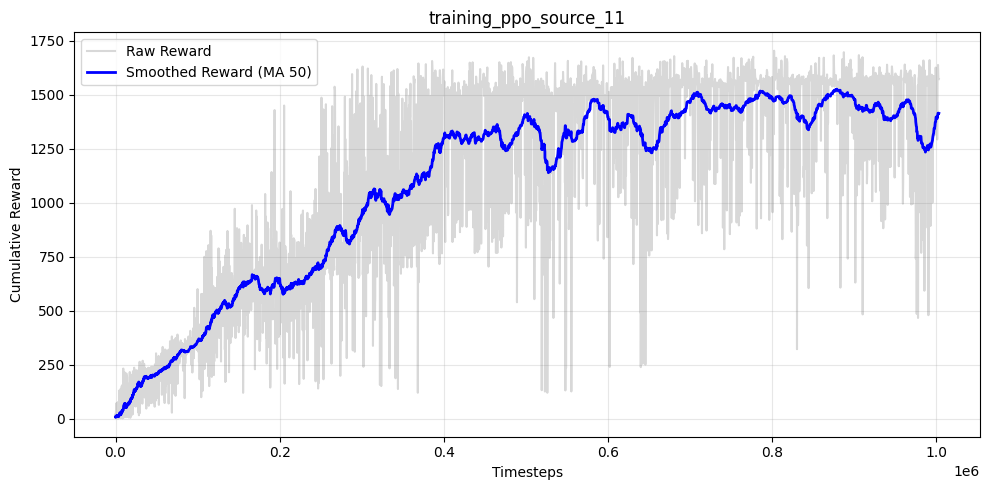

In [4]:
PPO_train(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)

In [5]:
mean, std = PPO_test(
    test_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_{SEED}'
)

--- Testing on CustomHopper-source-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1531.20 +/- 6.65
  Mean Steps:  500.00 +/- 0.00


Now, lets test it on target:

In [6]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---
Test Results:
  Mean Reward: 1367.62 +/- 202.90
  Mean Steps:  416.16 +/- 68.59


Now we train PPO on target and test it on target

Output()


--- Training on CustomHopper-target-v0 ---


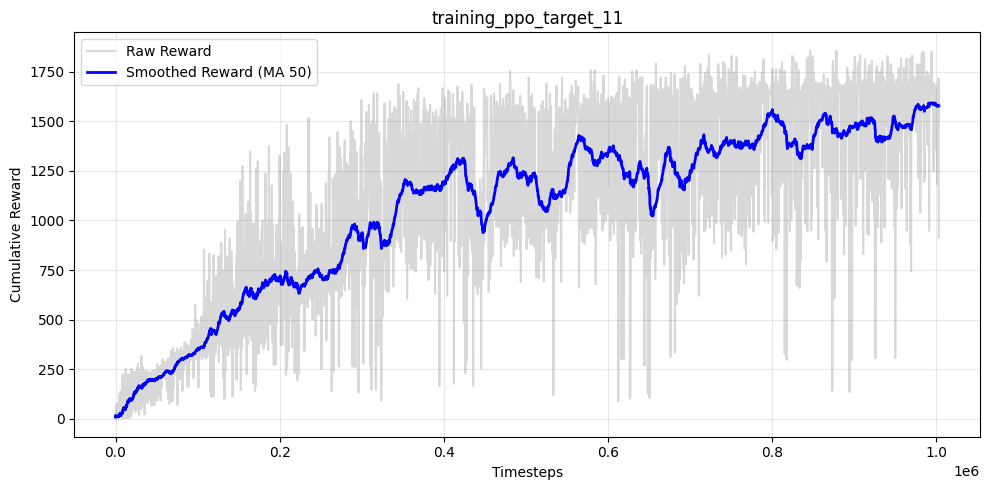

In [7]:
PPO_train(
    train_env_id='CustomHopper-target-v0',
    model_name=f'ppo_target_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)

In [8]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_target_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1705.66 +/- 3.72
  Mean Steps:  500.00 +/- 0.00


## UDR

Lets use UDR:

Output()


--- Training on CustomHopper-source-v0 using UDR ---


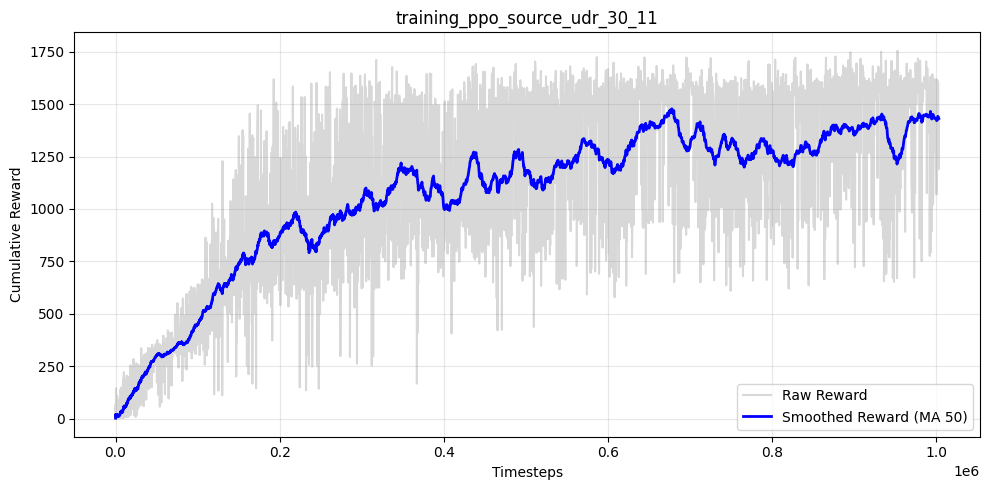

In [9]:
PPO_train_udr(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_udr_30_{SEED}',
    lr=3e-4,
    lr_scheduler_type='constant',
    steps=TIMESTEPS,
    udr_range=0.3,
    net_size="medium", # [ small - medium - large ] -> [ 64 - 128 - 256 ],
    seed=SEED
)

In [10]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_udr_30_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 906.60 +/- 35.29
  Mean Steps:  265.30 +/- 11.41


## ADR

Now, lets get serious and use Automatic Domain Randomization (OpenAI style, that is testing the borders before enlarging the distribution range):

Output()


--- Training on CustomHopper-source-v0 using ADR ---


[ADR Boundary Test] Range +/- 5.0% -> Reward: 250.32 +/- 0.8010102589328886

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 377.32 +/- 3.9569487106683585

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 634.29 +/- 8.270257532299219

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 831.27 +/- 24.830951034537826

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1456.07 +/- 67.83988976939125

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1422.37 +/- 26.74309349494737

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1353.93 +/- 36.9973357152342

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1447.45 +/- 26.94007207213827

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1505.41 +/- 131.35862832575103

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1531.67 +/- 91.54002912437495

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1582.35 +/- 98.75716071736504

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1481.93 +/- 178.38205410383156

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1477.89 +/- 167.74673016265055

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1568.27 +/- 199.1302313895382

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1360.48 +/- 277.4521180240698

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1617.32 +/- 88.29128292157642

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1394.50 +/- 312.81517100152956

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1423.94 +/- 293.5808517902964

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1409.90 +/- 261.4246243804293

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1543.12 +/- 151.6172945055589

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1508.24 +/- 292.3153832313081

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1300.61 +/- 260.68400557192655

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1440.80 +/- 375.21346696954816

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1220.76 +/- 322.44247168867304

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1517.61 +/- 282.79407763563825

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1538.39 +/- 251.0131286737357

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1325.68 +/- 266.208587999934

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1240.18 +/- 385.924949099098

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1372.74 +/- 368.68896104588987

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1553.16 +/- 319.04524083431886

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1691.24 +/- 94.52856689981289

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1601.88 +/- 278.03979919101806

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1516.14 +/- 348.4508181063857

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1577.79 +/- 251.78563358518252

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1395.91 +/- 403.7354903493226

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1390.97 +/- 413.9386269911477

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1530.99 +/- 277.51113006580084

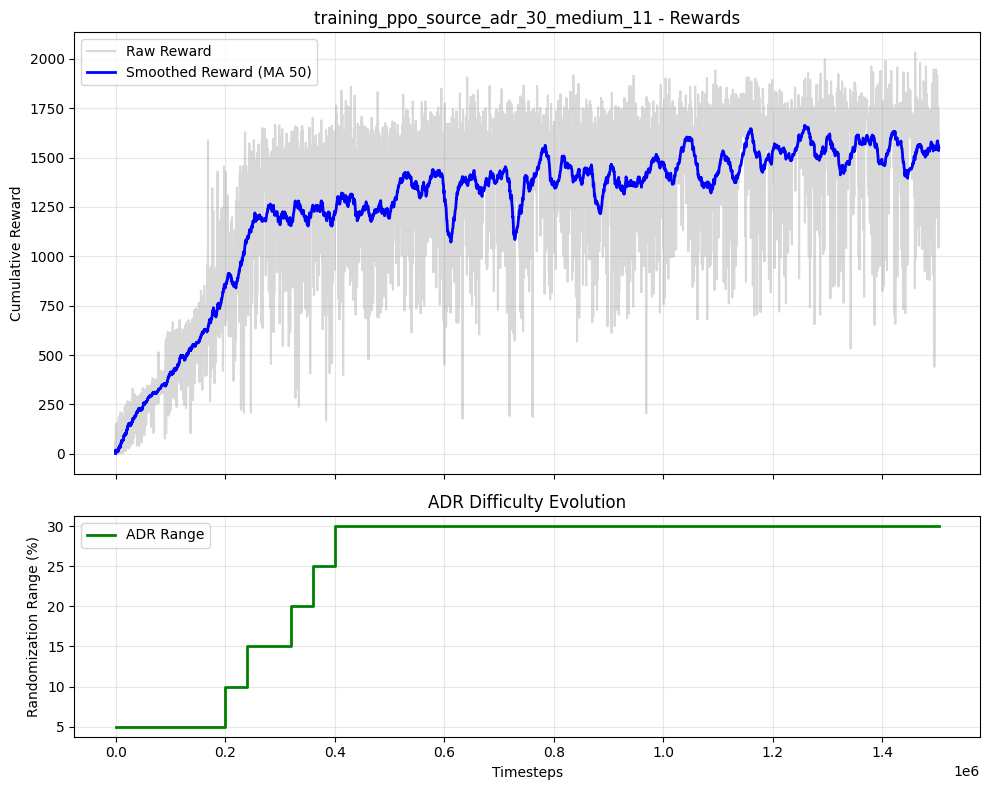

In [11]:
PPO_train_adr(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_adr_30_medium_{SEED}',
    lr=3e-4,
    lr_scheduler_type="constant",
    steps=1_500_000,
    starting_adr_range=0.05,
    objective_adr_range=0.3,
    increase_rate=0.05,
    reward_to_check=1400, # forse troppo alto ?
    check_frequency=40_000, # forse troppo alto ?
    net_size="medium",
    seed=SEED
)

Output()

c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 59.04 +/- 1.0141156969005936

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 231.14 +/- 1.0878668075314644

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 336.37 +/- 4.25977169310131

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 396.69 +/- 3.926695938645475

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 438.99 +/- 4.241516291056763

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 710.94 +/- 9.106302249724992

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1367.08 +/- 105.25836798665455

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1224.84 +/- 127.80958946070523

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1244.18 +/- 152.62733289741286

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1259.75 +/- 97.97404323315867

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1244.43 +/- 102.65514796168479

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1268.12 +/- 89.31328253673554

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1218.93 +/- 212.2198505798023

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1269.01 +/- 132.12809646321386

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1075.92 +/- 245.2416872749304

[ADR Boundary Test] Range +/- 30.0% -> Reward: 934.23 +/- 176.35392873188297

[ADR Boundary Test] Range +/- 30.0% -> Reward: 855.76 +/- 333.1635173168012

[ADR Boundary Test] Range +/- 30.0% -> Reward: 869.02 +/- 277.80769720962917

[ADR Boundary Test] Range +/- 30.0% -> Reward: 889.14 +/- 258.7159732646829

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1077.66 +/- 176.23258973722417

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1133.46 +/- 213.5508623987571

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1126.62 +/- 170.00750587563894

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1054.07 +/- 289.2964009201374

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1142.97 +/- 216.1955368201871

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1288.85 +/- 195.7895410367976

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1183.10 +/- 112.07610075850273

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1272.67 +/- 236.93944593924766

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1073.50 +/- 258.6171498352014

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1255.45 +/- 196.33225230113771

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1415.99 +/- 182.4233913476305

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1418.19 +/- 152.33852516461099

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1048.46 +/- 353.1802833611343

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1097.03 +/- 226.69601578501263

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1163.09 +/- 300.9456742261008

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1243.10 +/- 287.80598307803746

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1172.53 +/- 268.21038678262175

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1279.22 +/- 238.40218247730087

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1495.92 +/- 99.37960461360792

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1288.24 +/- 291.68111317817494

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1365.36 +/- 269.7394381295522

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1375.14 +/- 225.05188183647616

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1165.91 +/- 304.97472075545824

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1315.77 +/- 216.28441706765605

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1403.37 +/- 242.07571086102982

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1475.23 +/- 176.2765816281057

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1462.84 +/- 135.68168053902522

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1311.70 +/- 293.81247993448636

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1299.58 +/- 317.15437552919946

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1452.02 +/- 162.93085630541904

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1344.87 +/- 309.33891214994554

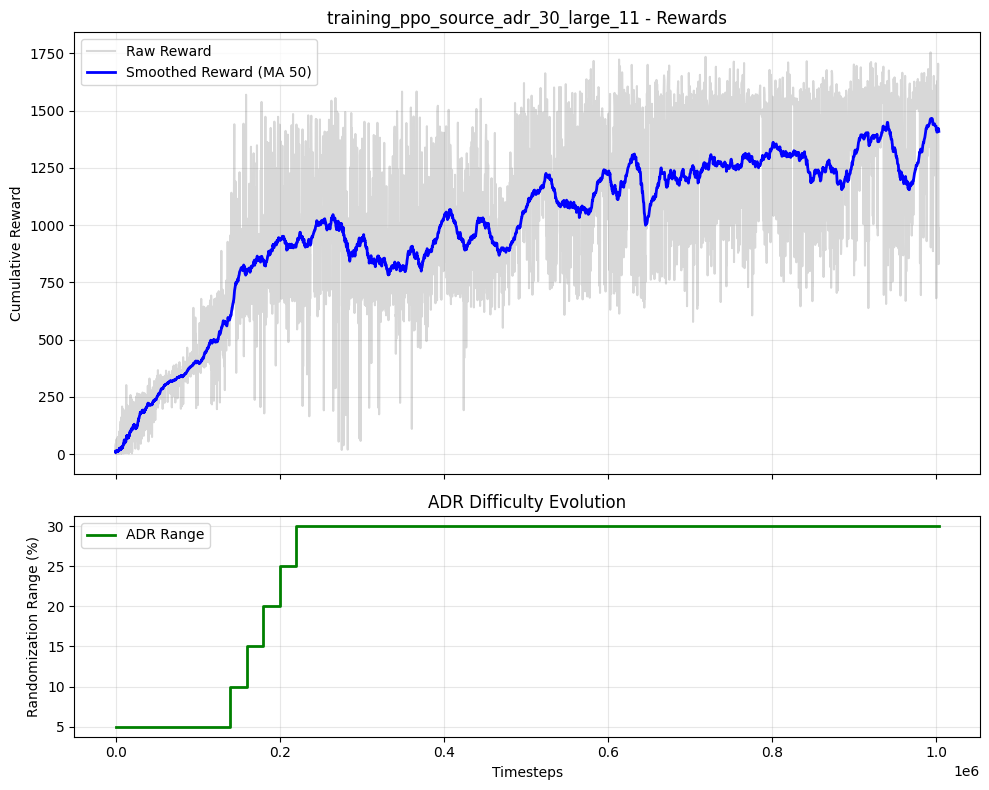

In [ ]:
# consigliata
PPO_train_adr(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_adr_30_large_{SEED}',
    lr=3e-4,
    lr_scheduler_type="constant",
    steps=TIMESTEPS, # 1.5M aiuterebbe
    starting_adr_range=0.05,
    objective_adr_range=0.3,
    increase_rate=0.05,
    reward_to_check=1200,   # <--- MODIFICA CRUCIALE: Lascialo salire prima
    check_frequency=20_000, # <--- Più reattivo
    net_size="large",       # <--- MODIFICA CRUCIALE: Più neuroni per gestire il caos
    seed=SEED
)

In [16]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_adr_30_medium_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---
Test Results:
  Mean Reward: 733.69 +/- 41.46
  Mean Steps:  214.12 +/- 6.78


## Visualization

In [ ]:
from utils.visualize_agent import visualize

model = f"ppo_source_adr_30_medium_{SEED}"

visualize(
    model_path=f"models/{model}",
    env_id="CustomHopper-target-v0"
)

Caricamento modello da: models/ppo_source_adr_30_123
Visualizzazione su ambiente: CustomHopper-target-v0
--- Episodio 1 ---
Reward Totale: 1490.08
--- Episodio 2 ---
Reward Totale: 1478.46
--- Episodio 3 ---
Reward Totale: 1732.99
--- Episodio 4 ---
Reward Totale: 1786.46
--- Episodio 5 ---
Reward Totale: 1505.09


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


# GRID SEARCH

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Total Progress:   0%|          | 0/24 [00:00<?, ?exp/s]

Running experiment with Objective ADR: 0.3, Reward threshold: 1200, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


Output()

c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 250.32 +/- 0.8010102589328886

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 377.32 +/- 3.9569487106683585

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 634.29 +/- 8.270257532299219

[ADR Boundary Test] Range +/- 5.0% -> Reward: 831.27 +/- 24.830951034537826

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1456.07 +/- 67.83988976939125

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1422.37 +/- 26.74309349494737

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1353.93 +/- 36.9973357152342

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1535.18 +/- 73.20424696733443

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1342.22 +/- 51.90847598922033

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1495.95 +/- 95.90401646216358

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1267.28 +/- 243.43594857096232

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1448.75 +/- 202.7864074781138

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1394.50 +/- 268.7045120949935

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1370.86 +/- 245.54278061610844

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1103.33 +/- 240.79482742324228

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1302.61 +/- 251.34976399790636

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1479.40 +/- 202.011453238362

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1257.38 +/- 337.42879424393317

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1305.32 +/- 307.2941283291494

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1372.95 +/- 161.73948775882315

[ADR Boundary Test] Range +/- 30.0% -> Reward: 996.43 +/- 264.4194027185582

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1454.59 +/- 236.44319187399805

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1464.08 +/- 409.2167559406881

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1378.87 +/- 365.359498666036

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1691.09 +/- 84.63404792503725

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1724.38 +/- 5.25
  Mean Steps:  500.00 +/- 0.00
Running experiment with Objective ADR: 0.3, Reward threshold: 1200, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 230.98 +/- 1.1731619920573118

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 393.96 +/- 3.017432606827781

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 708.93 +/- 8.38999279574761

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1042.09 +/- 93.65391070936226

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1383.12 +/- 70.35410104424922

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1394.33 +/- 91.79274709577741

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1316.38 +/- 208.65849942514836

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1277.09 +/- 151.94878565147542

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1164.22 +/- 282.9320288915642

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1341.19 +/- 193.4425434901964

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1539.10 +/- 118.2327597115597

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1498.69 +/- 137.72135799720348

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1335.85 +/- 306.4783728469494

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1575.89 +/- 239.60441334509935

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1450.80 +/- 265.2888166770342

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1602.49 +/- 122.95704973879023

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1573.13 +/- 175.86045182865607

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1606.09 +/- 149.4787291707605

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1486.36 +/- 225.50010704183532

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1529.90 +/- 99.22934671625148

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1494.62 +/- 299.52078868139967

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1679.53 +/- 207.09006502571992

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1620.59 +/- 255.5355773158405

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1595.99 +/- 205.71641269301554

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1661.69 +/- 197.3527277308397

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1585.96 +/- 210.42
  Mean Steps:  427.44 +/- 64.55
Running experiment with Objective ADR: 0.3, Reward threshold: 1200, Check freq: 80000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 379.50 +/- 5.011222028908925

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 810.10 +/- 18.687338964552726

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1378.30 +/- 92.57812826941615

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1406.64 +/- 80.72364470478642

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1542.93 +/- 144.68514996776884

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1296.68 +/- 325.38438110535543

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1543.70 +/- 215.05921761499366

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1410.72 +/- 277.0220857560766

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1234.39 +/- 398.10016525954563

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1543.97 +/- 237.79532735973055

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1482.93 +/- 282.98486018850093

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1542.17 +/- 240.06918984118

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1771.32 +/- 50.40
  Mean Steps:  498.84 +/- 3.67
Running experiment with Objective ADR: 0.3, Reward threshold: 1200, Check freq: 80000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 395.62 +/- 3.4782373425262603

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1097.16 +/- 125.04257762865605

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1390.88 +/- 89.72744121072499

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1440.85 +/- 192.68602684614436

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1373.32 +/- 144.54140327347054

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1234.97 +/- 231.88941182670092

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1349.55 +/- 258.1976616860179

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1154.91 +/- 230.20470275190524

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1225.95 +/- 305.0157717618938

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1537.13 +/- 238.58470158072532

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1608.45 +/- 217.23938281938302

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1661.65 +/- 186.2196425383935

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1136.38 +/- 108.57
  Mean Steps:  308.08 +/- 25.54
Running experiment with Objective ADR: 0.3, Reward threshold: 1500, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 250.32 +/- 0.8010102589328886

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 377.32 +/- 3.9569487106683585

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 634.29 +/- 8.270257532299219

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 831.27 +/- 24.830951034537826

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1456.07 +/- 67.83988976939125

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1355.28 +/- 48.64008788160894

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1358.83 +/- 80.93260341651295

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1533.44 +/- 28.403714246733063

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1372.11 +/- 18.933663074423073

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1662.95 +/- 81.13535124275852

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1595.33 +/- 46.99317901911505

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1560.17 +/- 61.02065684796057

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1229.64 +/- 330.24854162434804

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1498.64 +/- 199.5435736529339

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1510.29 +/- 228.7210021810391

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1546.43 +/- 150.71768714617244

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1485.90 +/- 217.71793770930162

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1582.83 +/- 163.76684275908445

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1456.59 +/- 269.2947490871787

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1484.99 +/- 283.9771894074301

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1595.84 +/- 227.07130121622063

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1500.87 +/- 338.6443279210826

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1590.88 +/- 357.4748856762704

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1723.36 +/- 128.16406443652627

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1472.50 +/- 311.5467707420008

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1181.42 +/- 66.16
  Mean Steps:  306.42 +/- 15.39
Running experiment with Objective ADR: 0.3, Reward threshold: 1500, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 230.98 +/- 1.1731619920573118

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 393.96 +/- 3.017432606827781

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 708.93 +/- 8.38999279574761

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1042.09 +/- 93.65391070936226

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1383.12 +/- 70.35410104424922

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1373.23 +/- 34.49948200189841

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1375.84 +/- 60.20491178069592

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1328.60 +/- 11.829696705972045

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1437.93 +/- 27.75160468007555

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1436.23 +/- 25.466135579403176

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1520.92 +/- 21.91158847827744

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1532.52 +/- 32.42990677780204

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1532.36 +/- 156.3343502009844

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1400.02 +/- 245.43461833191364

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1476.41 +/- 279.54982174415835

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1585.22 +/- 212.49094473343933

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1364.94 +/- 326.67278134973725

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1490.00 +/- 278.432802778101

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1659.70 +/- 170.46704138993599

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1270.63 +/- 272.82962438359846

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1536.58 +/- 357.81963827775877

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1587.49 +/- 250.6171978500001

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1557.83 +/- 352.3016599558479

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1363.15 +/- 294.4319315493897

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1488.28 +/- 467.0714578421721

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1006.31 +/- 13.39
  Mean Steps:  270.26 +/- 3.53
Running experiment with Objective ADR: 0.3, Reward threshold: 1500, Check freq: 80000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 379.50 +/- 5.011222028908925

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 810.10 +/- 18.687338964552726

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1378.30 +/- 92.57812826941615

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1531.62 +/- 22.012358198325014

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1605.97 +/- 68.34758059634301

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1503.72 +/- 211.9802278606024

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1536.71 +/- 169.77270923828945

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1369.44 +/- 217.58654056546965

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1629.01 +/- 154.25074022851317

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1371.07 +/- 335.33422678046566

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1638.96 +/- 196.36141068686945

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1610.83 +/- 204.77696446954224

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1014.32 +/- 14.33
  Mean Steps:  270.76 +/- 4.20
Running experiment with Objective ADR: 0.3, Reward threshold: 1500, Check freq: 80000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 395.62 +/- 3.4782373425262603

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1097.16 +/- 125.04257762865605

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1390.88 +/- 89.72744121072499

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1330.44 +/- 13.905123003726258

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1425.08 +/- 26.470997560190895

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1567.56 +/- 9.31799885090945

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1618.65 +/- 21.685964977238953

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1441.87 +/- 272.5970418101933

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1734.28 +/- 76.02779856387052

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1432.12 +/- 301.63844699205424

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1691.54 +/- 101.93736418924219

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1683.11 +/- 93.64321564134072

[ADR Boundary Increased] New Range +/- 30.0%

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1188.47 +/- 52.94
  Mean Steps:  321.72 +/- 12.98
Running experiment with Objective ADR: 0.5, Reward threshold: 1200, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 250.32 +/- 0.8010102589328886

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 377.32 +/- 3.9569487106683585

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 634.29 +/- 8.270257532299219

[ADR Boundary Test] Range +/- 5.0% -> Reward: 831.27 +/- 24.830951034537826

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1456.07 +/- 67.83988976939125

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1422.37 +/- 26.74309349494737

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1353.93 +/- 36.9973357152342

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1535.18 +/- 73.20424696733443

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1342.22 +/- 51.90847598922033

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1495.95 +/- 95.90401646216358

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1402.09 +/- 191.80348378582934

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1458.41 +/- 117.68406881651286

[ADR Boundary Increased] New Range +/- 45.0%

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1269.69 +/- 317.91092212397956

[ADR Boundary Increased] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1132.84 +/- 222.56451307422398

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1332.13 +/- 257.4312893209284

[ADR Objective Boundary Reached] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1347.10 +/- 211.26816768438786

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1237.16 +/- 286.83848076154277

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1242.69 +/- 252.3354356570386

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1214.46 +/- 411.47305558765754

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1106.31 +/- 286.3440565000386

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1225.71 +/- 265.1648797817247

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1429.98 +/- 361.23529117806885

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1384.34 +/- 446.17845927520824

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1353.07 +/- 247.5191245011164

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1489.62 +/- 395.4135975572331

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1314.21 +/- 132.58
  Mean Steps:  349.88 +/- 33.43
Running experiment with Objective ADR: 0.5, Reward threshold: 1200, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 230.98 +/- 1.1731619920573118

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 393.96 +/- 3.017432606827781

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 708.93 +/- 8.38999279574761

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1042.09 +/- 93.65391070936226

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1383.12 +/- 70.35410104424922

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1394.33 +/- 91.79274709577741

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1316.38 +/- 208.65849942514836

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1277.09 +/- 151.94878565147542

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1164.22 +/- 282.9320288915642

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1341.19 +/- 193.4425434901964

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1539.10 +/- 118.2327597115597

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1474.24 +/- 129.56871083898093

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1119.52 +/- 367.1572733694411

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1485.15 +/- 241.5904855278657

[ADR Boundary Increased] New Range +/- 45.0%

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1413.64 +/- 148.59423913157943

[ADR Boundary Increased] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1260.78 +/- 510.9831563043321

[ADR Objective Boundary Reached] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1338.54 +/- 206.04467235487022

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1154.54 +/- 399.0114382192382

[ADR Boundary Test] Range +/- 50.0% -> Reward: 800.83 +/- 397.3847471932909

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1267.31 +/- 189.78791659454393

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1457.10 +/- 353.50704688762704

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1222.69 +/- 160.69000003788858

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1237.83 +/- 323.30253882787457

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1177.33 +/- 372.9183245392488

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1279.11 +/- 496.5509429566271

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 846.66 +/- 16.05
  Mean Steps:  238.08 +/- 3.20
Running experiment with Objective ADR: 0.5, Reward threshold: 1200, Check freq: 80000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 379.50 +/- 5.011222028908925

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 810.10 +/- 18.687338964552726

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1378.30 +/- 92.57812826941615

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1406.64 +/- 80.72364470478642

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1542.93 +/- 144.68514996776884

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1296.68 +/- 325.38438110535543

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1543.70 +/- 215.05921761499366

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1410.72 +/- 277.0220857560766

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1323.56 +/- 280.6935445980898

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1386.69 +/- 276.5498300895506

[ADR Boundary Increased] New Range +/- 45.0%

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1427.97 +/- 349.142425608743

[ADR Boundary Increased] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1628.48 +/- 178.6193433081579

[ADR Objective Boundary Reached] New Range +/- 50.0%

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1769.18 +/- 84.72
  Mean Steps:  487.92 +/- 26.97
Running experiment with Objective ADR: 0.5, Reward threshold: 1200, Check freq: 80000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 395.62 +/- 3.4782373425262603

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1097.16 +/- 125.04257762865605

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1390.88 +/- 89.72744121072499

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1440.85 +/- 192.68602684614436

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1373.32 +/- 144.54140327347054

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1234.97 +/- 231.88941182670092

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1349.55 +/- 258.1976616860179

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1154.91 +/- 230.20470275190524

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1225.95 +/- 305.0157717618938

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1325.37 +/- 365.5191633827899

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1352.51 +/- 376.8836017739916

[ADR Boundary Increased] New Range +/- 45.0%

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1393.24 +/- 346.1582675785327

[ADR Boundary Increased] New Range +/- 50.0%

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 704.34 +/- 2.34
  Mean Steps:  213.88 +/- 0.77
Running experiment with Objective ADR: 0.5, Reward threshold: 1500, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 250.32 +/- 0.8010102589328886

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 377.32 +/- 3.9569487106683585

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 634.29 +/- 8.270257532299219

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 831.27 +/- 24.830951034537826

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1456.07 +/- 67.83988976939125

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1355.28 +/- 48.64008788160894

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1358.83 +/- 80.93260341651295

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1533.44 +/- 28.403714246733063

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1372.11 +/- 18.933663074423073

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1662.95 +/- 81.13535124275852

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1595.33 +/- 46.99317901911505

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1560.17 +/- 61.02065684796057

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1229.64 +/- 330.24854162434804

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1498.64 +/- 199.5435736529339

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1510.29 +/- 228.7210021810391

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1546.43 +/- 150.71768714617244

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1634.67 +/- 218.03290696700242

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1588.39 +/- 187.3029427088171

[ADR Boundary Increased] New Range +/- 45.0%

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1256.61 +/- 344.0876948300005

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1223.47 +/- 247.98190868738533

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1398.44 +/- 475.16209817472674

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1591.90 +/- 227.94329210058837

[ADR Boundary Increased] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1538.53 +/- 363.68555595897897

[ADR Objective Boundary Reached] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1716.45 +/- 239.11038317020032

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1541.54 +/- 393.1148674000327

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1404.33 +/- 99.75
  Mean Steps:  377.20 +/- 23.23
Running experiment with Objective ADR: 0.5, Reward threshold: 1500, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 230.98 +/- 1.1731619920573118

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 393.96 +/- 3.017432606827781

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 708.93 +/- 8.38999279574761

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1042.09 +/- 93.65391070936226

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1383.12 +/- 70.35410104424922

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1373.23 +/- 34.49948200189841

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1375.84 +/- 60.20491178069592

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1328.60 +/- 11.829696705972045

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1437.93 +/- 27.75160468007555

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1436.23 +/- 25.466135579403176

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1520.92 +/- 21.91158847827744

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1532.52 +/- 32.42990677780204

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1532.36 +/- 156.3343502009844

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1400.02 +/- 245.43461833191364

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1476.41 +/- 279.54982174415835

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1585.22 +/- 212.49094473343933

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1364.94 +/- 326.67278134973725

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1490.00 +/- 278.432802778101

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1659.70 +/- 170.46704138993599

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1270.63 +/- 272.82962438359846

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1536.58 +/- 357.81963827775877

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1406.18 +/- 241.40239834146183

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1346.21 +/- 401.05128265099154

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1559.97 +/- 196.97723622346587

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1557.67 +/- 401.15377176272233

[ADR Boundary Increased] New Range +/- 45.0%

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 979.96 +/- 24.47
  Mean Steps:  267.86 +/- 5.35
Running experiment with Objective ADR: 0.5, Reward threshold: 1500, Check freq: 80000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 379.50 +/- 5.011222028908925

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 810.10 +/- 18.687338964552726

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1378.30 +/- 92.57812826941615

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1531.62 +/- 22.012358198325014

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1605.97 +/- 68.34758059634301

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1503.72 +/- 211.9802278606024

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1369.44 +/- 217.58654056546965

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1629.01 +/- 154.25074022851317

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1371.07 +/- 335.33422678046566

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1638.96 +/- 196.36141068686945

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1574.40 +/- 196.73921421031673

[ADR Boundary Increased] New Range +/- 40.0%

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 668.50 +/- 5.83
  Mean Steps:  196.96 +/- 1.40
Running experiment with Objective ADR: 0.5, Reward threshold: 1500, Check freq: 80000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 395.62 +/- 3.4782373425262603

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1097.16 +/- 125.04257762865605

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1390.88 +/- 89.72744121072499

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1330.44 +/- 13.905123003726258

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1425.08 +/- 26.470997560190895

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1567.56 +/- 9.31799885090945

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1618.65 +/- 21.685964977238953

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1441.87 +/- 272.5970418101933

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1734.28 +/- 76.02779856387052

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1432.12 +/- 301.63844699205424

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1691.54 +/- 101.93736418924219

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1683.11 +/- 93.64321564134072

[ADR Boundary Increased] New Range +/- 30.0%

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1191.36 +/- 54.36
  Mean Steps:  322.54 +/- 13.51
Running experiment with Objective ADR: 0.7, Reward threshold: 1200, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 250.32 +/- 0.8010102589328886

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 377.32 +/- 3.9569487106683585

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 634.29 +/- 8.270257532299219

[ADR Boundary Test] Range +/- 5.0% -> Reward: 831.27 +/- 24.830951034537826

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1456.07 +/- 67.83988976939125

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1422.37 +/- 26.74309349494737

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1353.93 +/- 36.9973357152342

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1535.18 +/- 73.20424696733443

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1342.22 +/- 51.90847598922033

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1495.95 +/- 95.90401646216358

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1402.09 +/- 191.80348378582934

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1458.41 +/- 117.68406881651286

[ADR Boundary Increased] New Range +/- 45.0%

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1269.69 +/- 317.91092212397956

[ADR Boundary Increased] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1132.84 +/- 222.56451307422398

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1332.13 +/- 257.4312893209284

[ADR Boundary Increased] New Range +/- 55.0%

[ADR Boundary Test] Range +/- 55.0% -> Reward: 1302.81 +/- 348.2689032106931

[ADR Boundary Increased] New Range +/- 60.0%

[ADR Boundary Test] Range +/- 60.0% -> Reward: 1110.93 +/- 270.69752190356365

[ADR Boundary Test] Range +/- 60.0% -> Reward: 1291.90 +/- 263.7168062849811

[ADR Boundary Increased] New Range +/- 65.0%

[ADR Boundary Test] Range +/- 65.0% -> Reward: 1200.53 +/- 361.0311561099382

[ADR Objective Boundary Reached] New Range +/- 70.0%

[ADR Boundary Test] Range +/- 70.0% -> Reward: 1092.76 +/- 202.42284392714691

[ADR Boundary Test] Range +/- 70.0% -> Reward: 1163.56 +/- 329.1709361278921

[ADR Boundary Test] Range +/- 70.0% -> Reward: 1242.05 +/- 213.00723664822343

[ADR Boundary Test] Range +/- 70.0% -> Reward: 1408.81 +/- 420.38864371018684

[ADR Boundary Test] Range +/- 70.0% -> Reward: 883.64 +/- 329.83953025700544

[ADR Boundary Test] Range +/- 70.0% -> Reward: 1029.46 +/- 313.2072545284795

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 725.04 +/- 6.01
  Mean Steps:  211.46 +/- 1.33
Running experiment with Objective ADR: 0.7, Reward threshold: 1200, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 230.98 +/- 1.1731619920573118

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 393.96 +/- 3.017432606827781

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 708.93 +/- 8.38999279574761

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1042.09 +/- 93.65391070936226

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1383.12 +/- 70.35410104424922

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1394.33 +/- 91.79274709577741

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1316.38 +/- 208.65849942514836

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1277.09 +/- 151.94878565147542

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1164.22 +/- 282.9320288915642

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1341.19 +/- 193.4425434901964

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1539.10 +/- 118.2327597115597

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1474.24 +/- 129.56871083898093

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1119.52 +/- 367.1572733694411

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1485.15 +/- 241.5904855278657

[ADR Boundary Increased] New Range +/- 45.0%

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1413.64 +/- 148.59423913157943

[ADR Boundary Increased] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1260.78 +/- 510.9831563043321

[ADR Boundary Increased] New Range +/- 55.0%

[ADR Boundary Test] Range +/- 55.0% -> Reward: 1308.97 +/- 184.21998672724663

[ADR Boundary Increased] New Range +/- 60.0%

[ADR Boundary Test] Range +/- 60.0% -> Reward: 1257.06 +/- 298.72940406823216

[ADR Boundary Increased] New Range +/- 65.0%

[ADR Boundary Test] Range +/- 65.0% -> Reward: 988.23 +/- 278.7953179214101

[ADR Boundary Test] Range +/- 65.0% -> Reward: 1066.08 +/- 310.38305001157573

[ADR Boundary Test] Range +/- 65.0% -> Reward: 983.76 +/- 307.50655755248044

[ADR Boundary Test] Range +/- 65.0% -> Reward: 1086.91 +/- 315.56230272124833

[ADR Boundary Test] Range +/- 65.0% -> Reward: 987.80 +/- 416.0162912041887

[ADR Boundary Test] Range +/- 65.0% -> Reward: 1103.62 +/- 224.4051787733762

[ADR Boundary Test] Range +/- 65.0% -> Reward: 885.03 +/- 419.47751491885606

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 948.52 +/- 20.43
  Mean Steps:  258.78 +/- 3.97
Running experiment with Objective ADR: 0.7, Reward threshold: 1200, Check freq: 80000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 379.50 +/- 5.011222028908925

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 810.10 +/- 18.687338964552726

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1378.30 +/- 92.57812826941615

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1406.64 +/- 80.72364470478642

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1542.93 +/- 144.68514996776884

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1296.68 +/- 325.38438110535543

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1543.70 +/- 215.05921761499366

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1410.72 +/- 277.0220857560766

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1323.56 +/- 280.6935445980898

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1386.69 +/- 276.5498300895506

[ADR Boundary Increased] New Range +/- 45.0%

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1427.97 +/- 349.142425608743

[ADR Boundary Increased] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1628.48 +/- 178.6193433081579

[ADR Boundary Increased] New Range +/- 55.0%

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 395.62 +/- 3.4782373425262603

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1097.16 +/- 125.04257762865605

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1390.88 +/- 89.72744121072499

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1440.85 +/- 192.68602684614436

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1373.32 +/- 144.54140327347054

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1234.97 +/- 231.88941182670092

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1349.55 +/- 258.1976616860179

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1154.91 +/- 230.20470275190524

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1225.95 +/- 305.0157717618938

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1325.37 +/- 365.5191633827899

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1352.51 +/- 376.8836017739916

[ADR Boundary Increased] New Range +/- 45.0%

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1393.24 +/- 346.1582675785327

[ADR Boundary Increased] New Range +/- 50.0%

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 704.34 +/- 2.00
  Mean Steps:  213.88 +/- 0.68
Running experiment with Objective ADR: 0.7, Reward threshold: 1500, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 250.32 +/- 0.8010102589328886

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 377.32 +/- 3.9569487106683585

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 634.29 +/- 8.270257532299219

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 831.27 +/- 24.830951034537826

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1456.07 +/- 67.83988976939125

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1355.28 +/- 48.64008788160894

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1358.83 +/- 80.93260341651295

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1533.44 +/- 28.403714246733063

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1372.11 +/- 18.933663074423073

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1662.95 +/- 81.13535124275852

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1595.33 +/- 46.99317901911505

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1560.17 +/- 61.02065684796057

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1229.64 +/- 330.24854162434804

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1498.64 +/- 199.5435736529339

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1510.29 +/- 228.7210021810391

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1546.43 +/- 150.71768714617244

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1634.67 +/- 218.03290696700242

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1588.39 +/- 187.3029427088171

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1256.61 +/- 344.0876948300005

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1223.47 +/- 247.98190868738533

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1398.44 +/- 475.16209817472674

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1591.90 +/- 227.94329210058837

[ADR Boundary Increased] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1538.53 +/- 363.68555595897897

[ADR Boundary Increased] New Range +/- 55.0%

[ADR Boundary Test] Range +/- 55.0% -> Reward: 1118.89 +/- 376.3334815818833

[ADR Boundary Test] Range +/- 55.0% -> Reward: 1501.69 +/- 455.1674526016904

[ADR Boundary Increased] New Range +/- 60.0%

c:\Users\Fabio\Desktop\POLI\Robot Learning\RLProject\utils\plot.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})


--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 1308.44 +/- 151.99
  Mean Steps:  355.10 +/- 43.01
Running experiment with Objective ADR: 0.7, Reward threshold: 1500, Check freq: 40000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 230.98 +/- 1.1731619920573118

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 393.96 +/- 3.017432606827781

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 708.93 +/- 8.38999279574761

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1042.09 +/- 93.65391070936226

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1383.12 +/- 70.35410104424922

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1373.23 +/- 34.49948200189841

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1375.84 +/- 60.20491178069592

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1328.60 +/- 11.829696705972045

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1437.93 +/- 27.75160468007555

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1436.23 +/- 25.466135579403176

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1520.92 +/- 21.91158847827744

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1532.52 +/- 32.42990677780204

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1532.36 +/- 156.3343502009844

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1400.02 +/- 245.43461833191364

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1476.41 +/- 279.54982174415835

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1585.22 +/- 212.49094473343933

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1364.94 +/- 326.67278134973725

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1490.00 +/- 278.432802778101

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1659.70 +/- 170.46704138993599

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1270.63 +/- 272.82962438359846

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1536.58 +/- 357.81963827775877

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1406.18 +/- 241.40239834146183

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1346.21 +/- 401.05128265099154

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1559.97 +/- 196.97723622346587

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1557.67 +/- 401.15377176272233

[ADR Boundary Increased] New Range +/- 45.0%

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 989.20 +/- 29.88
  Mean Steps:  269.84 +/- 6.62
Running experiment with Objective ADR: 0.7, Reward threshold: 1500, Check freq: 80000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 379.50 +/- 5.011222028908925

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 810.10 +/- 18.687338964552726

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1378.30 +/- 92.57812826941615

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1531.62 +/- 22.012358198325014

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1605.97 +/- 68.34758059634301

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1503.72 +/- 211.9802278606024

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1536.71 +/- 169.77270923828945

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1369.44 +/- 217.58654056546965

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1629.01 +/- 154.25074022851317

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1371.07 +/- 335.33422678046566

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1638.96 +/- 196.36141068686945

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1574.40 +/- 196.73921421031673

[ADR Boundary Increased] New Range +/- 40.0%

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Test Results:
  Mean Reward: 668.22 +/- 5.66
  Mean Steps:  196.84 +/- 1.29
Running experiment with Objective ADR: 0.7, Reward threshold: 1500, Check freq: 80000

--- Training on CustomHopper-source-v0 using ADR ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70:
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 395.62 +/- 3.4782373425262603

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1097.16 +/- 125.04257762865605

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1390.88 +/- 89.72744121072499

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1330.44 +/- 13.905123003726258

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1425.08 +/- 26.470997560190895

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1567.56 +/- 9.31799885090945

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1618.65 +/- 21.685964977238953

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1441.87 +/- 272.5970418101933

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1734.28 +/- 76.02779856387052

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1432.12 +/- 301.63844699205424

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1691.54 +/- 101.93736418924219

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1683.11 +/- 93.64321564134072

[ADR Boundary Increased] New Range +/- 30.0%

--- Testing on CustomHopper-target-v0 ---


c:\Users\Fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1184.27 +/- 58.15
  Mean Steps:  320.94 +/- 14.16


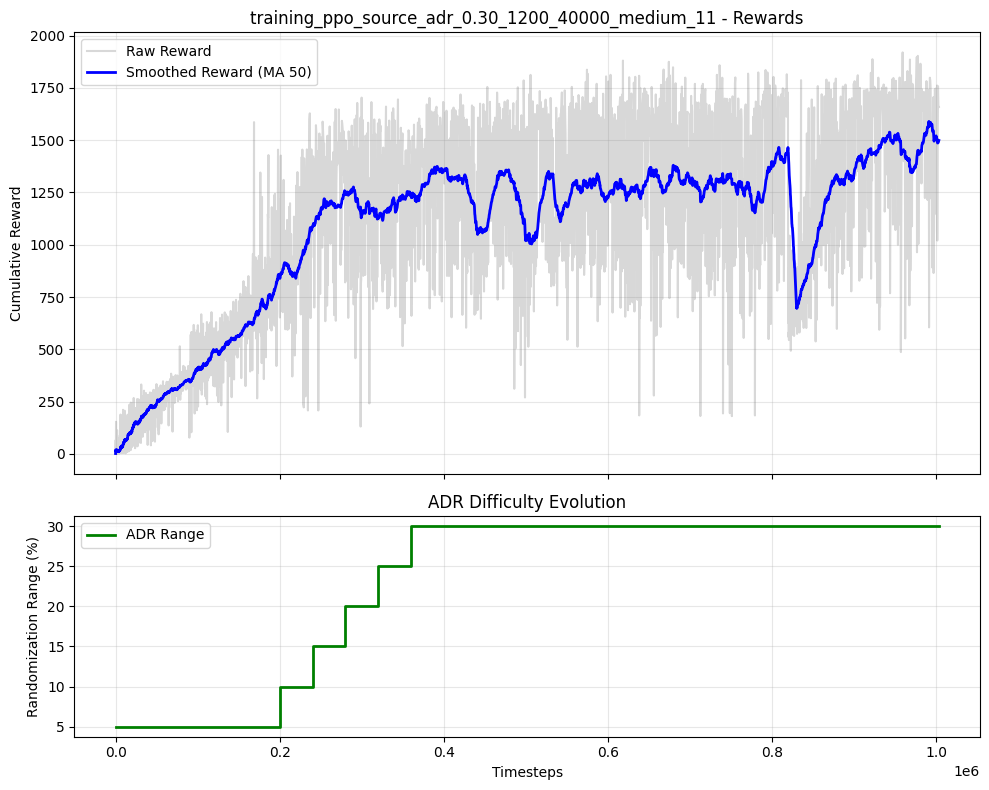

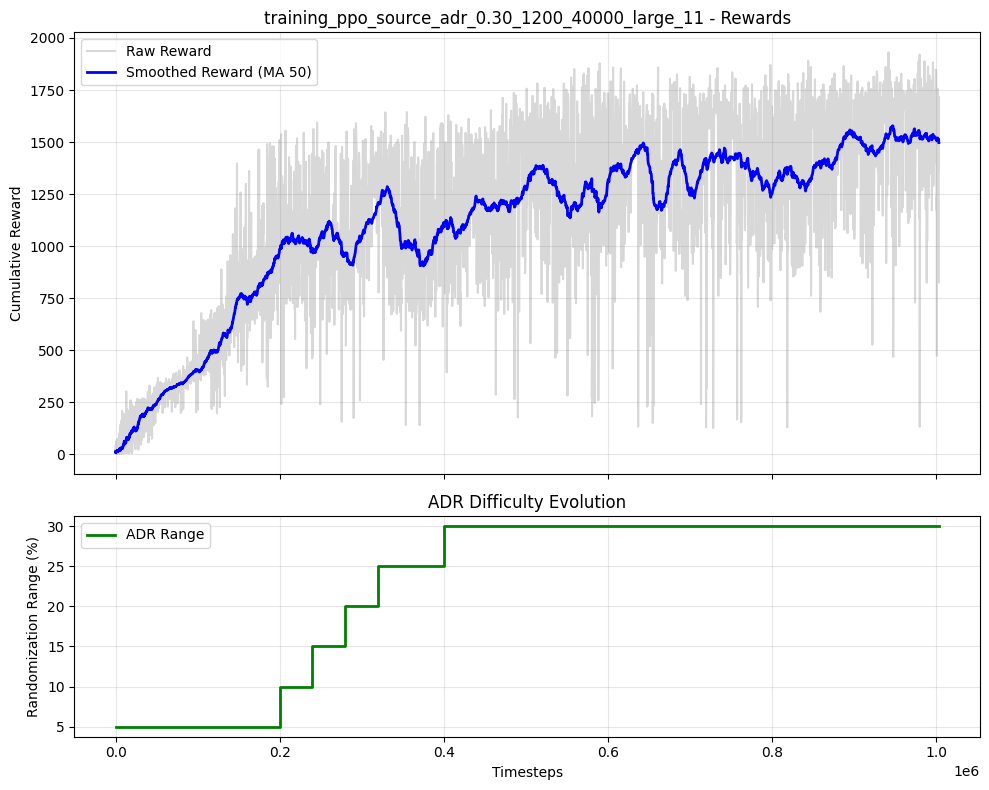

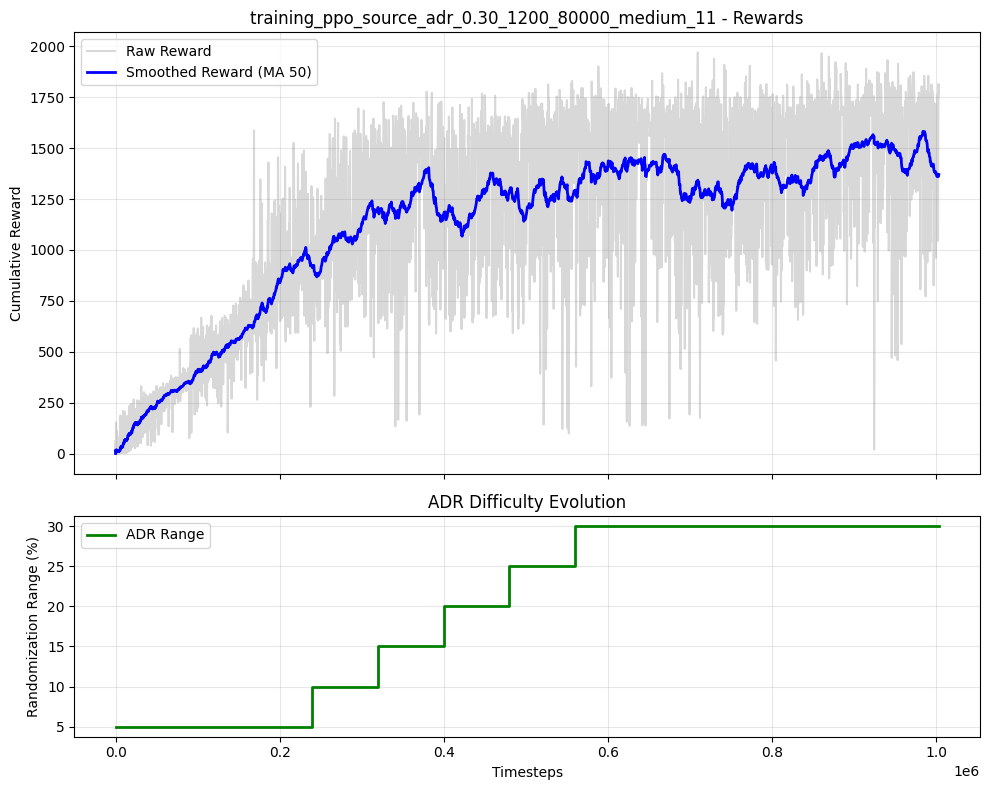

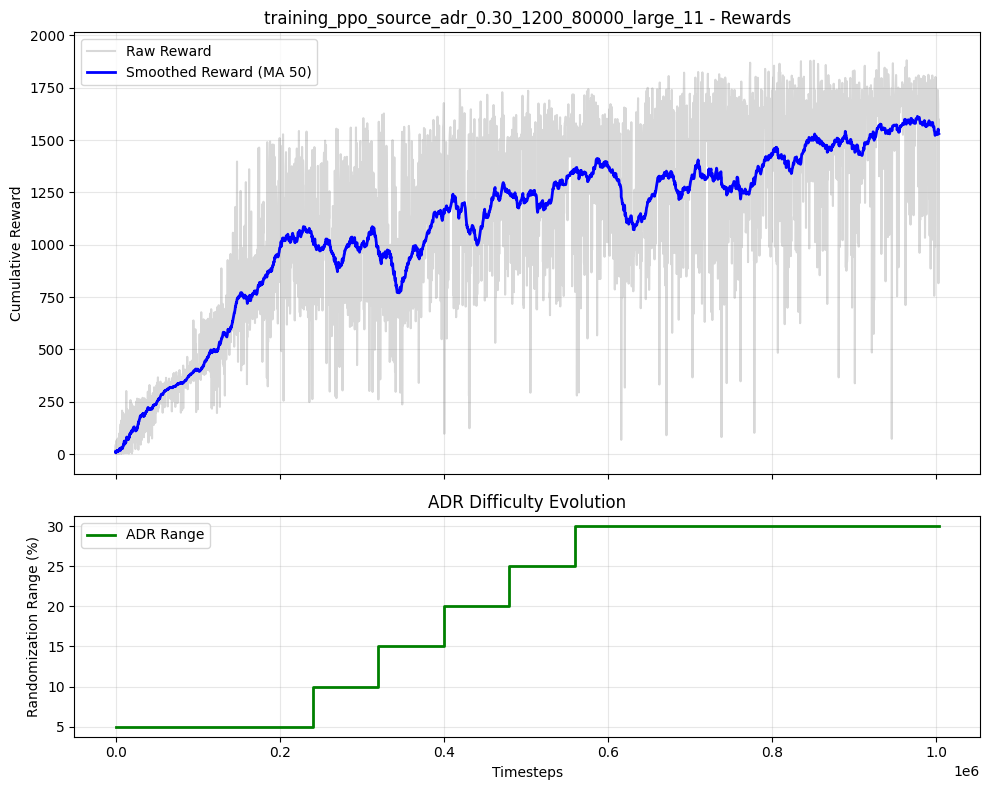

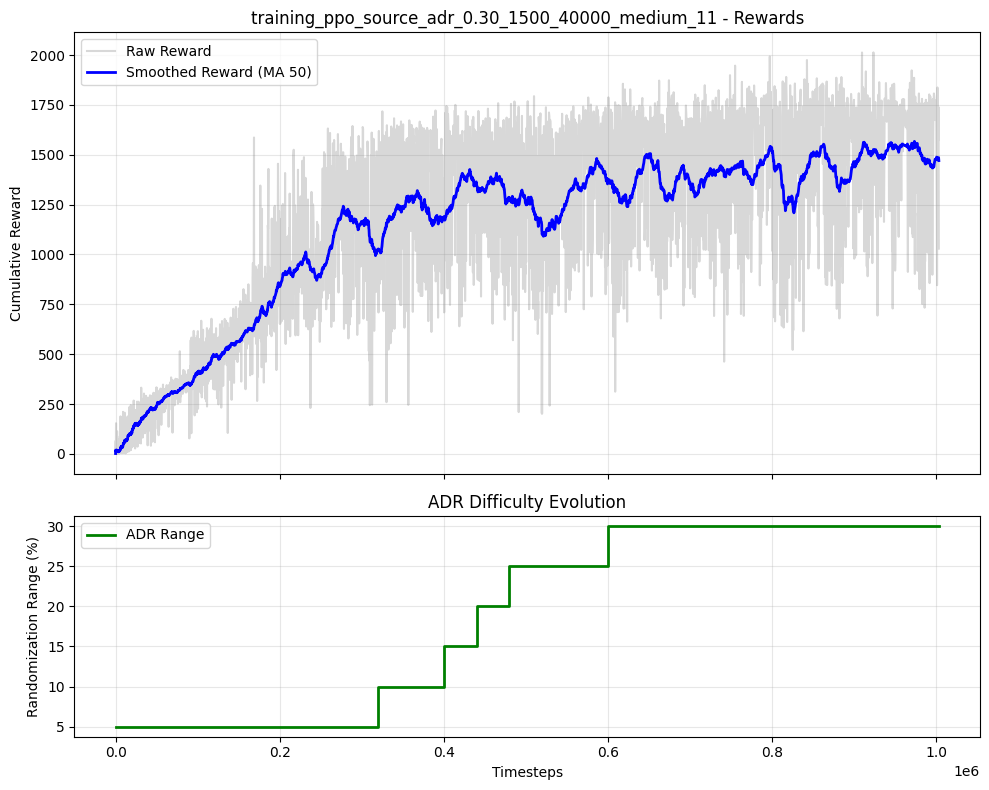

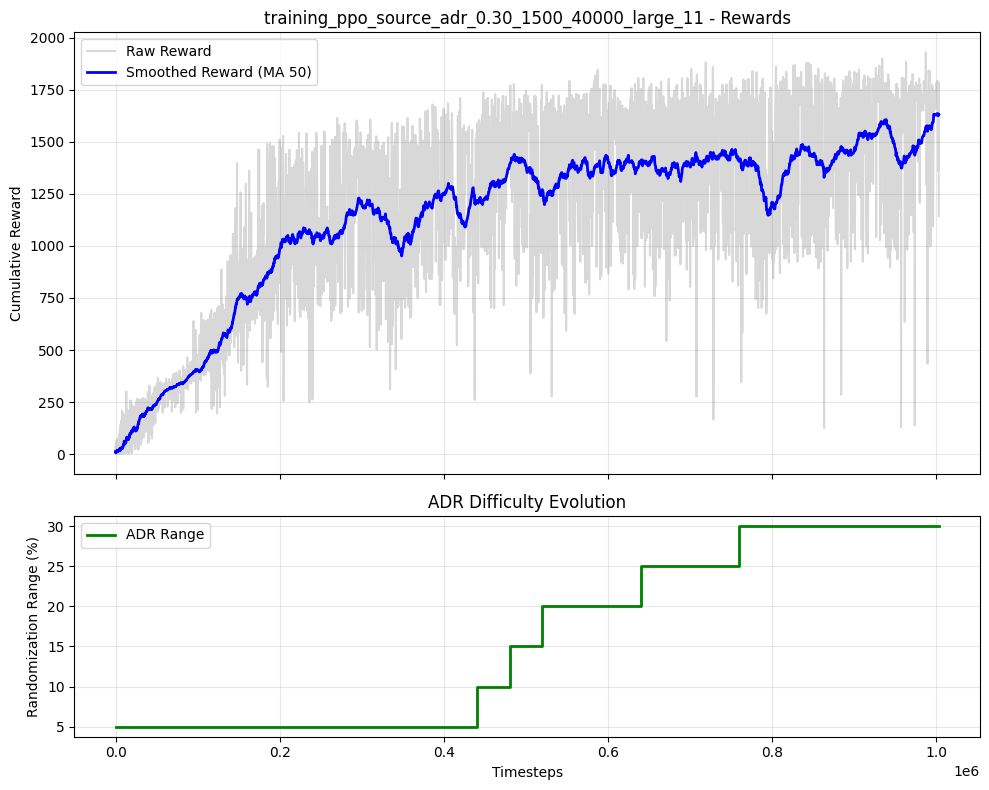

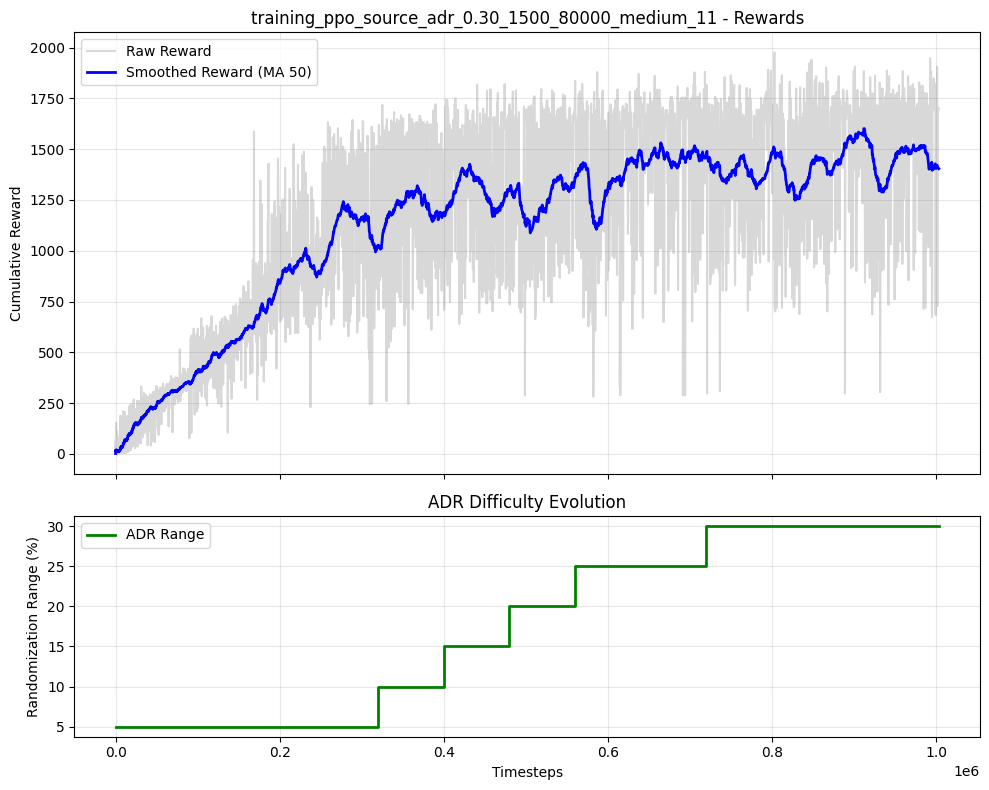

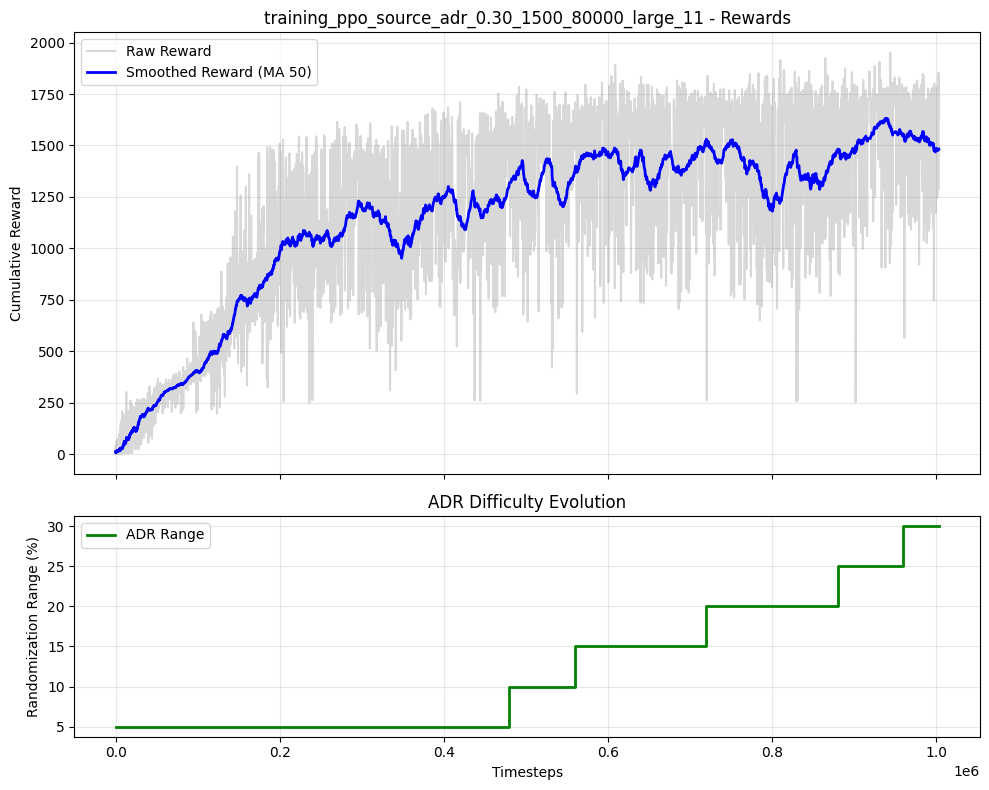

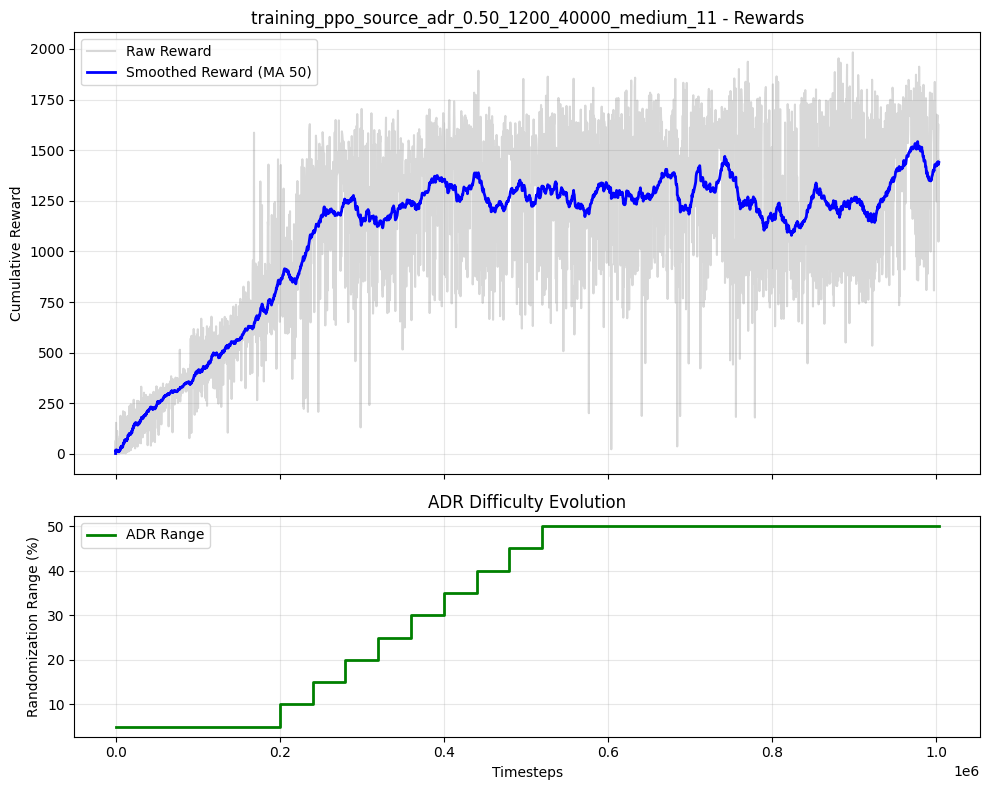

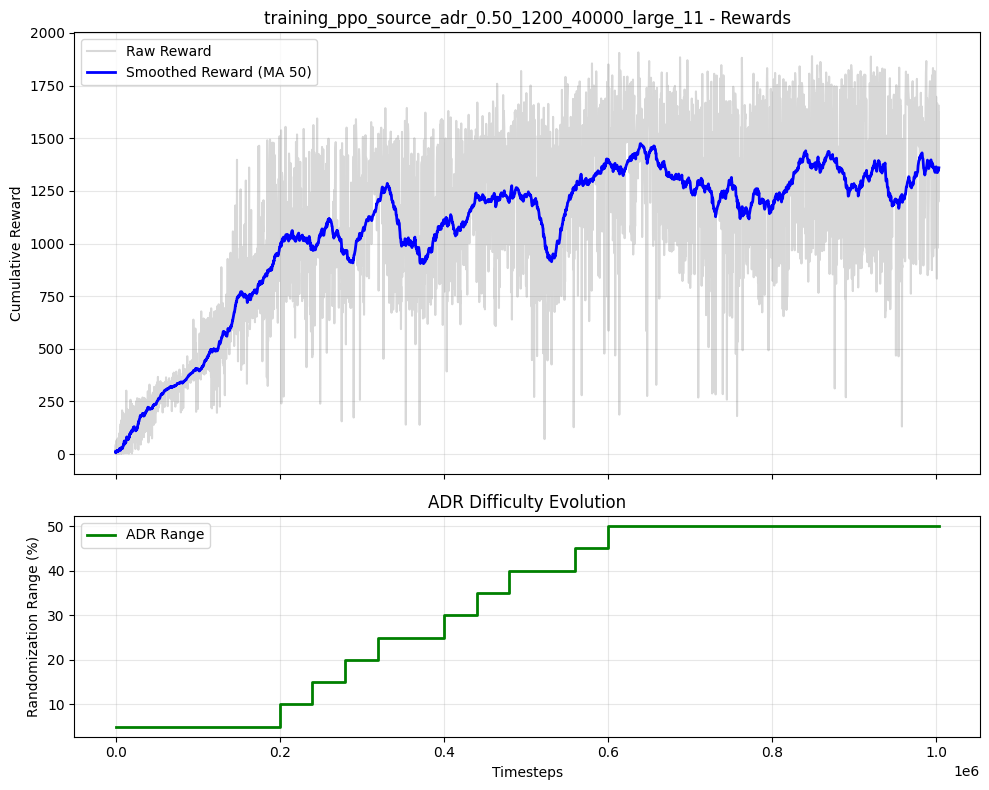

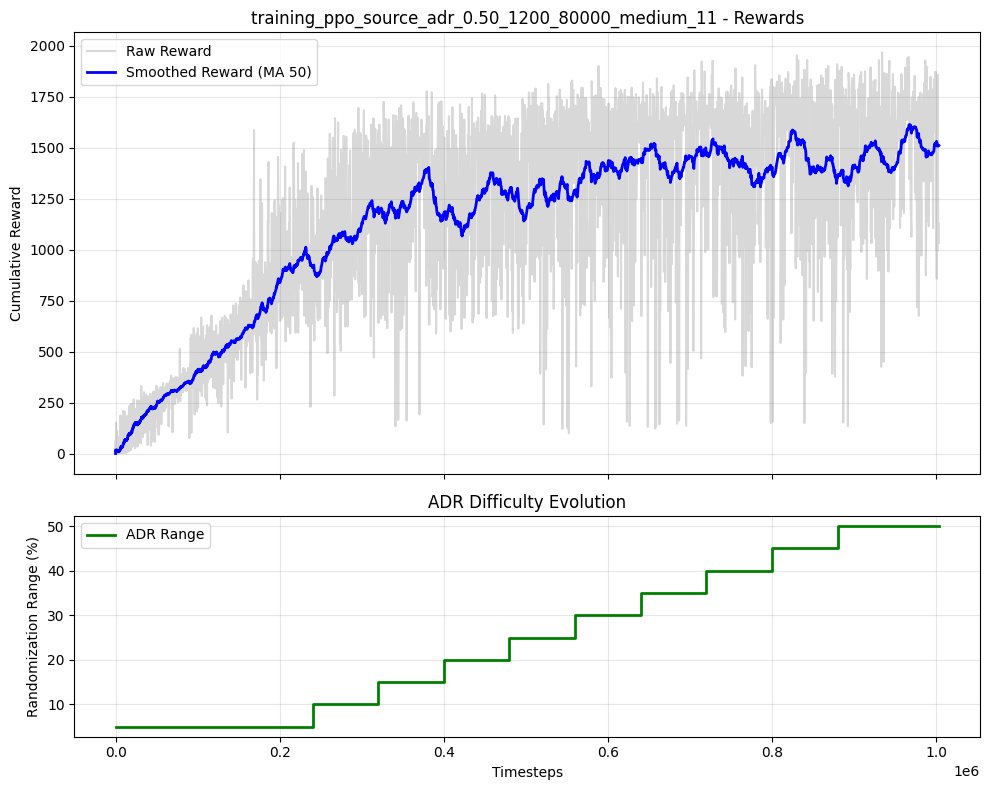

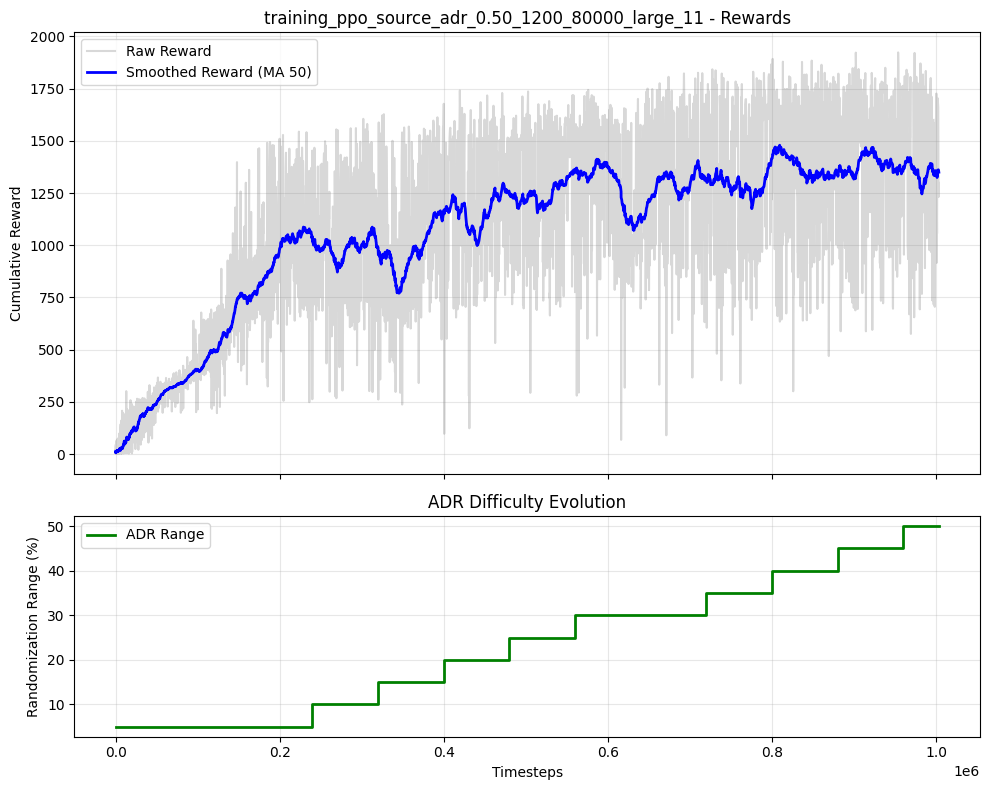

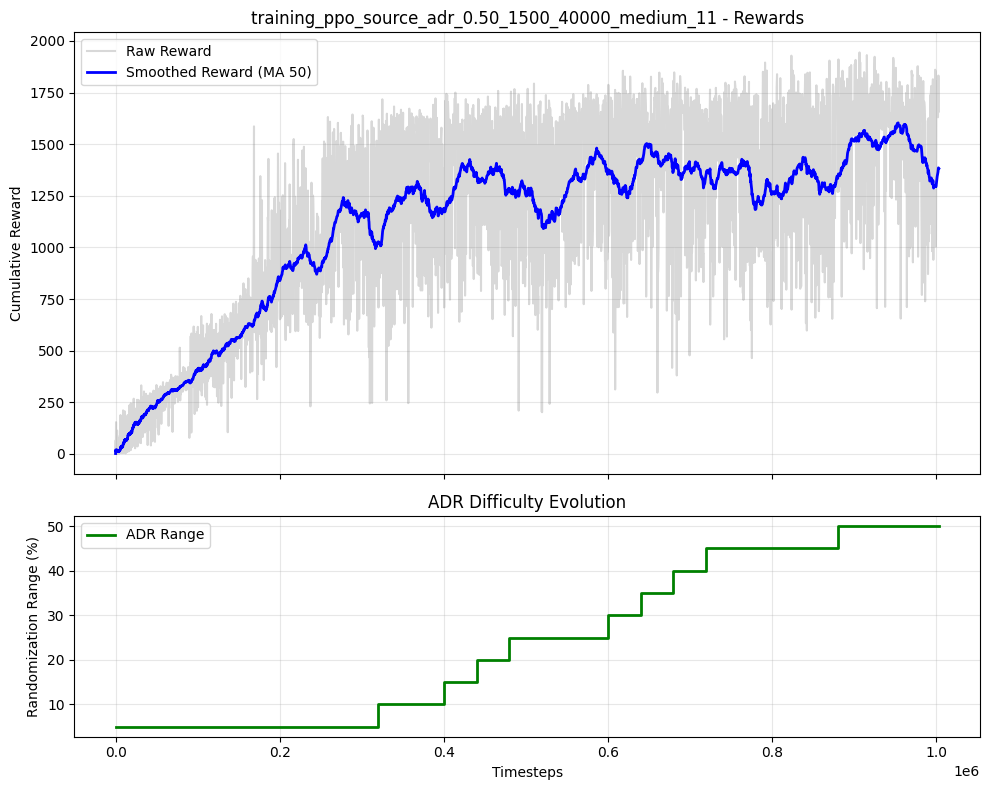

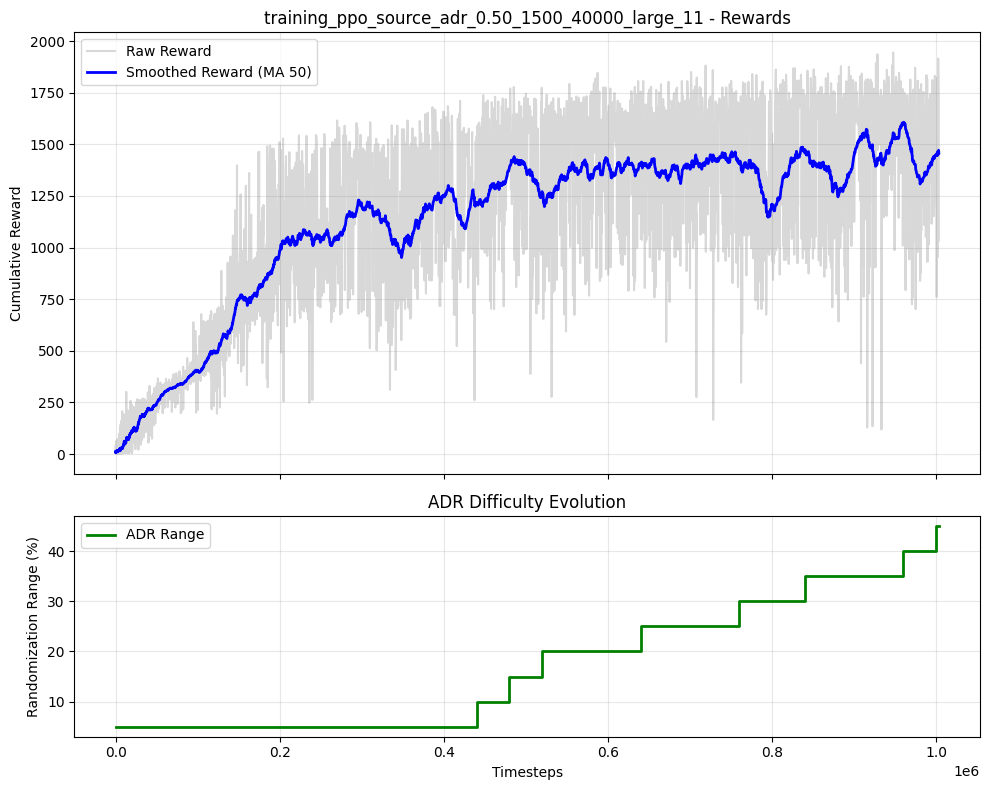

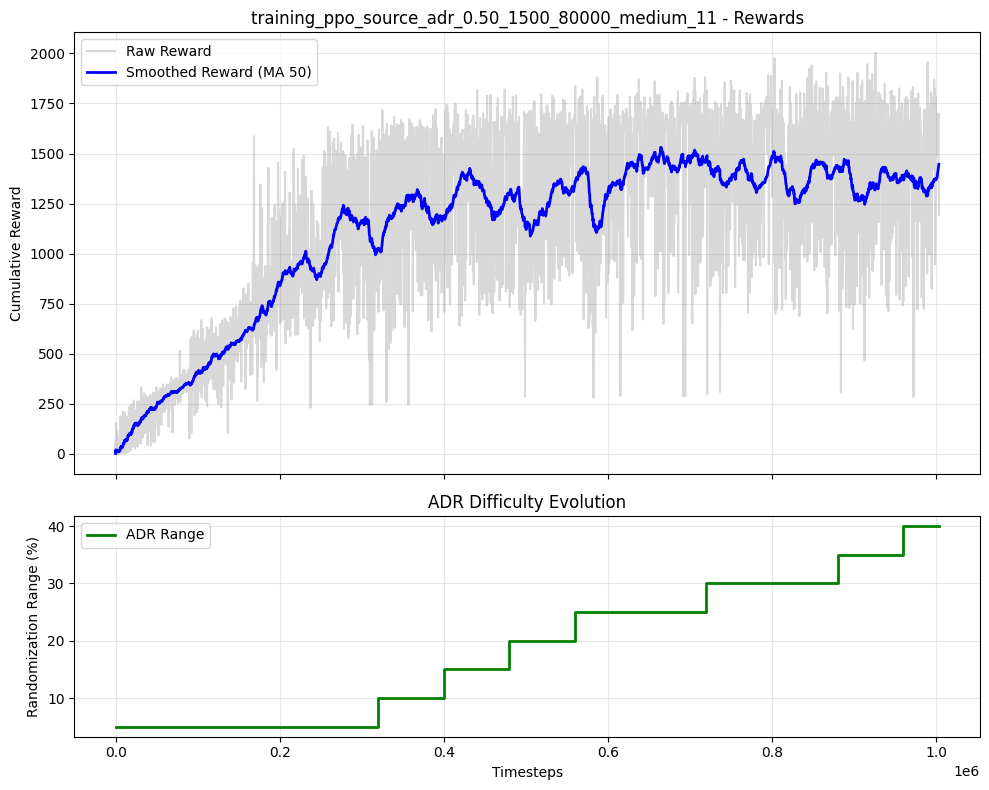

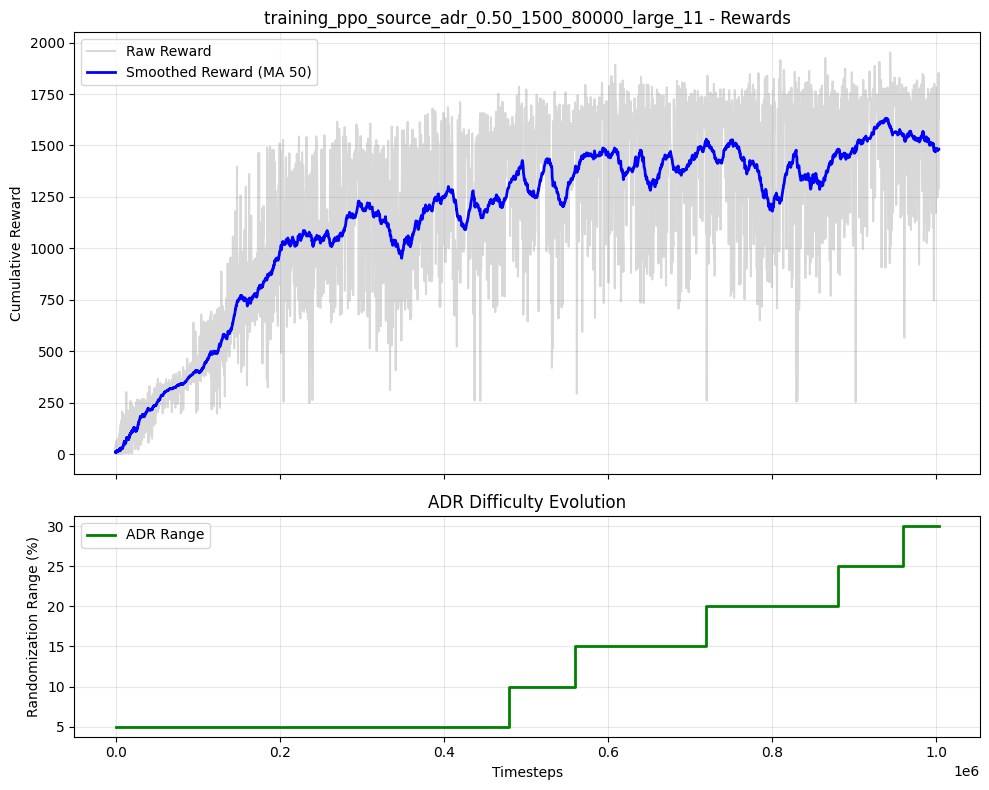

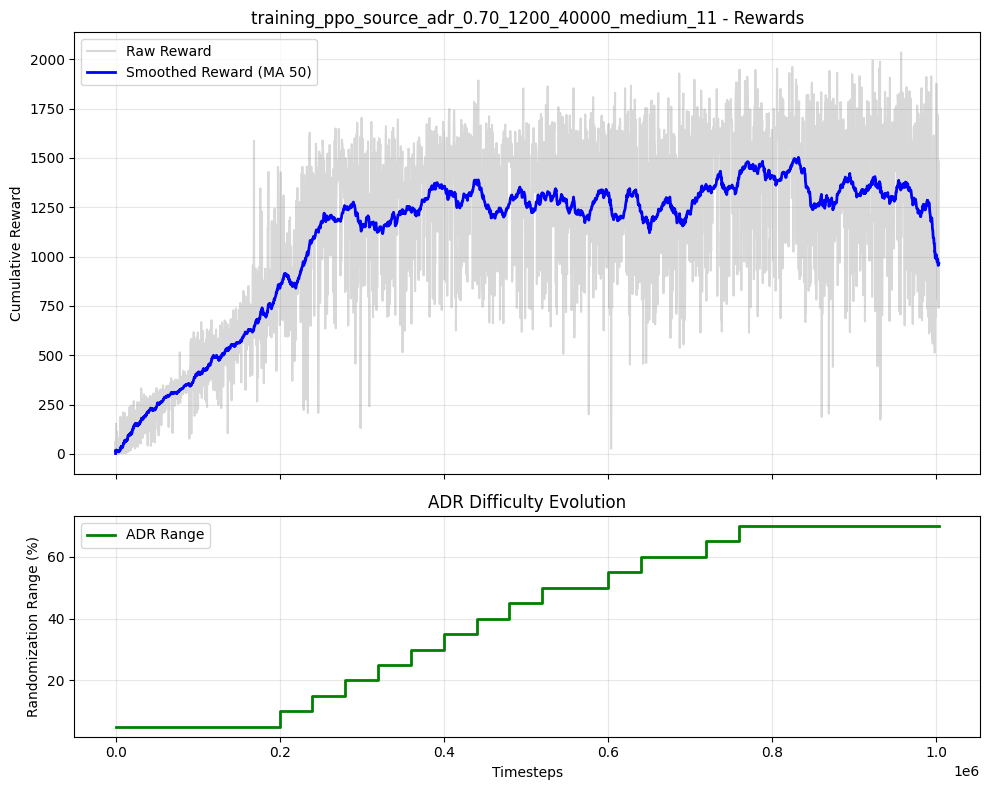

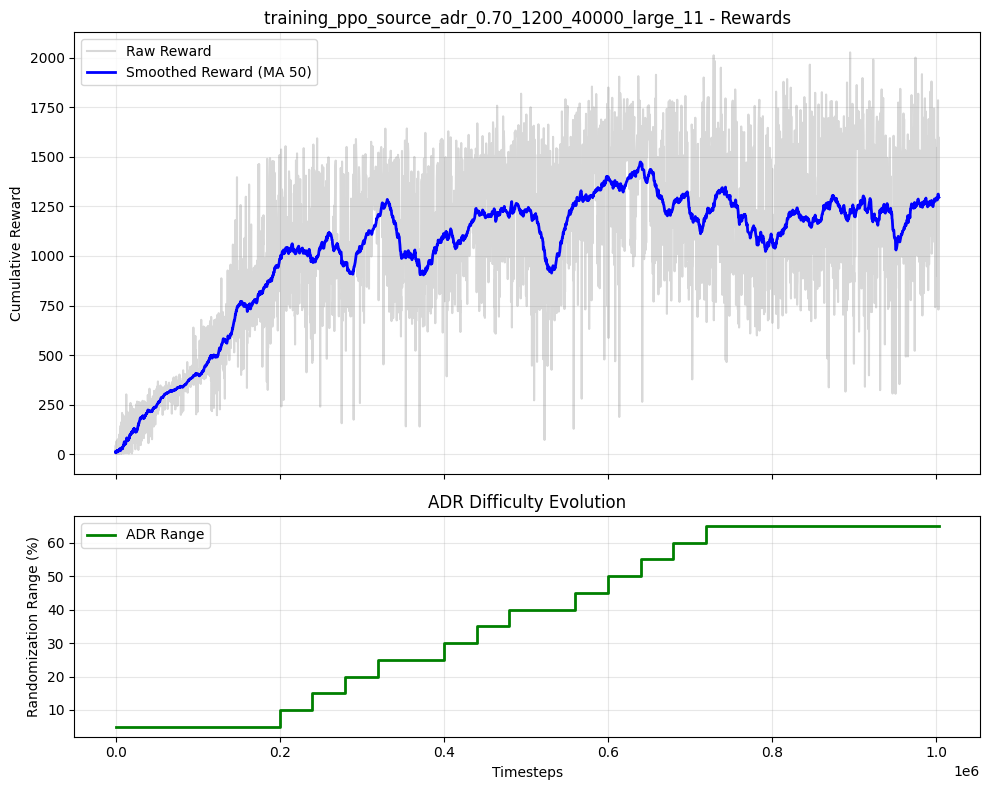

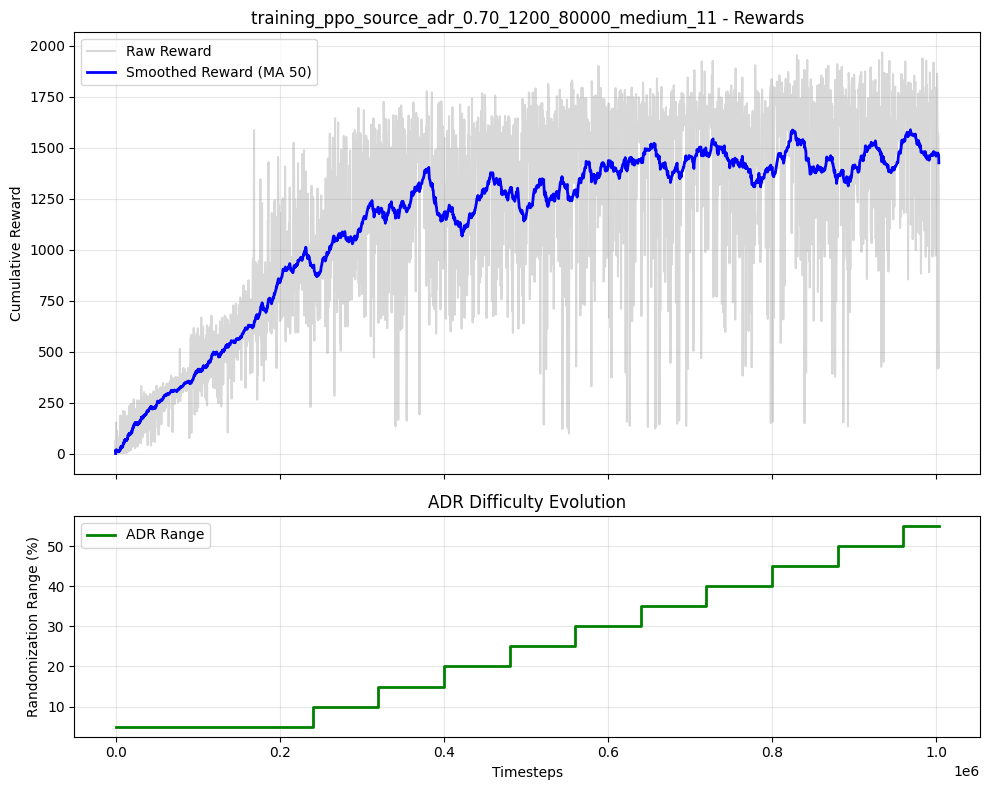

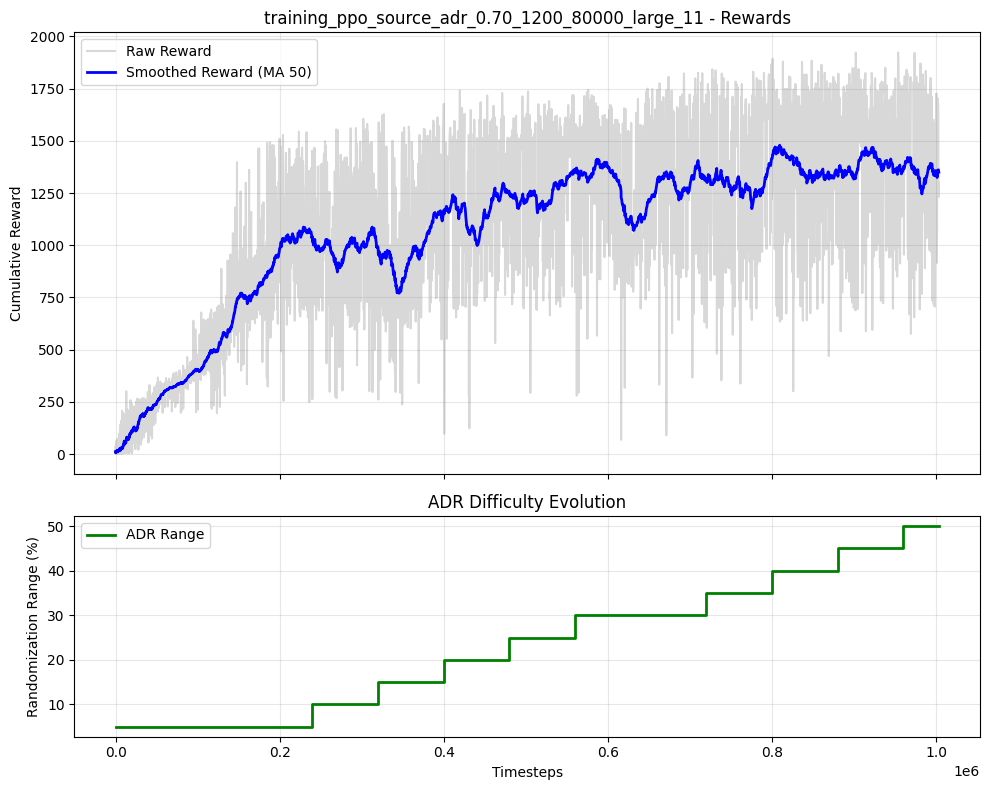

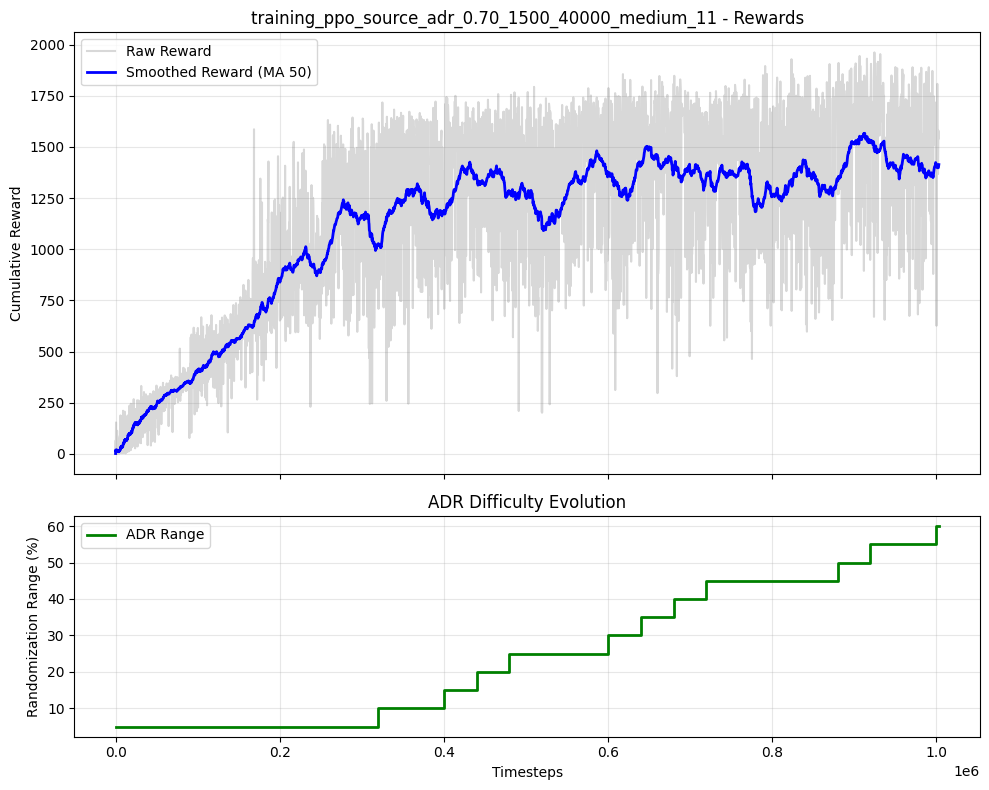

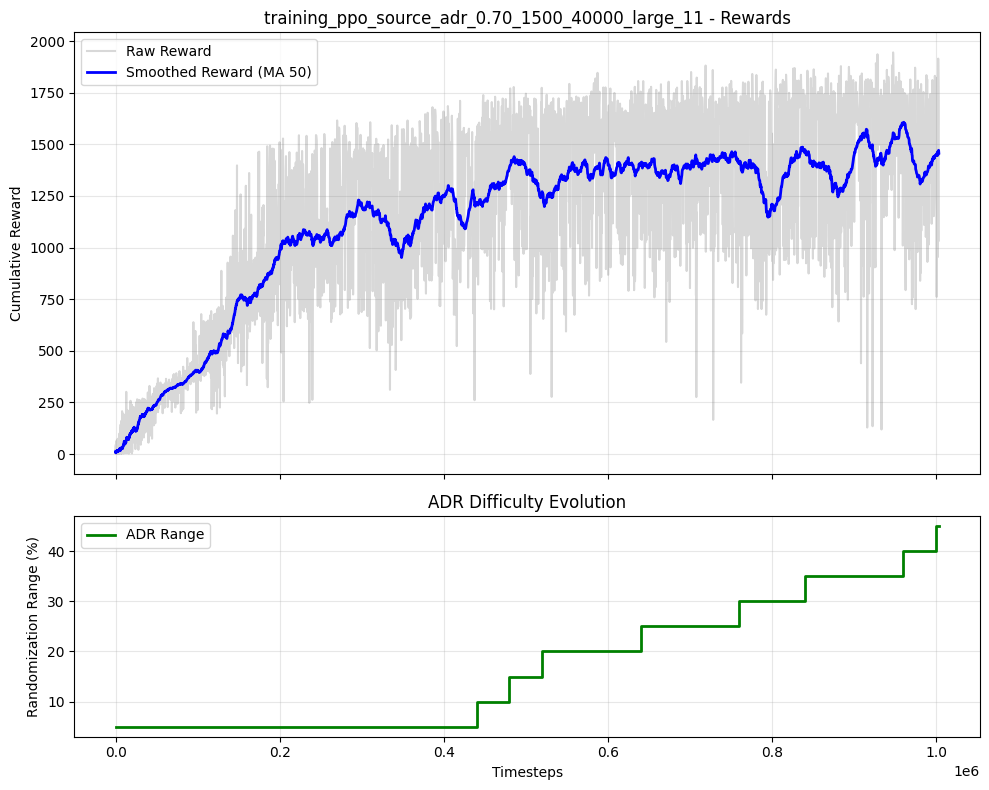

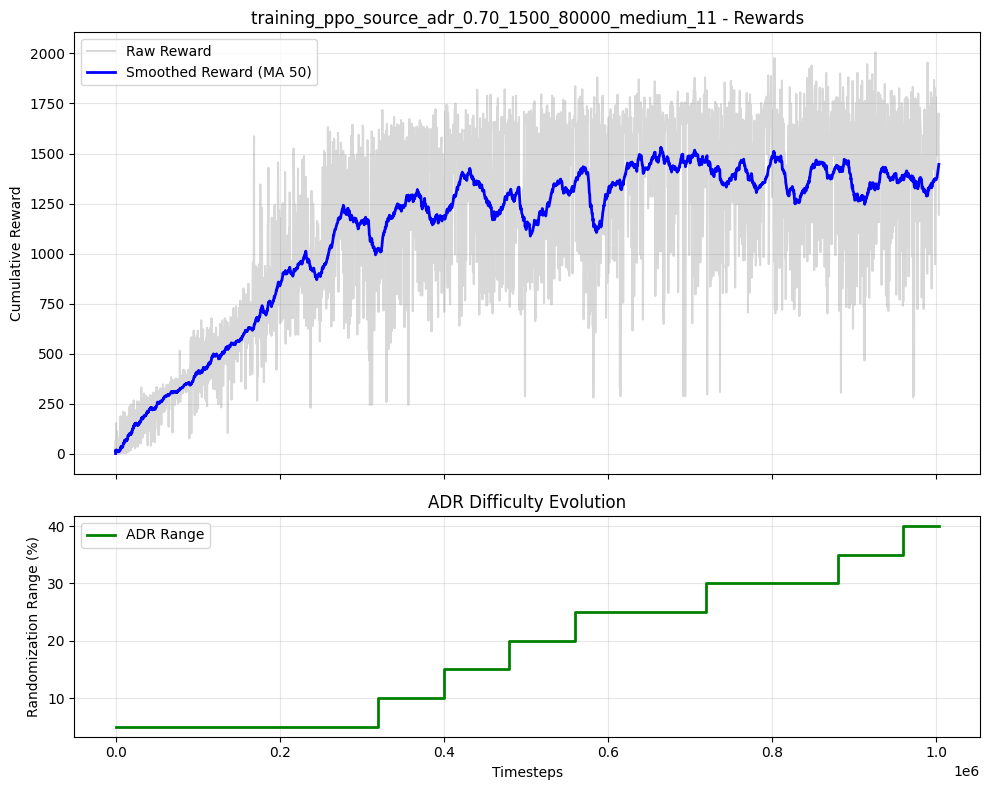

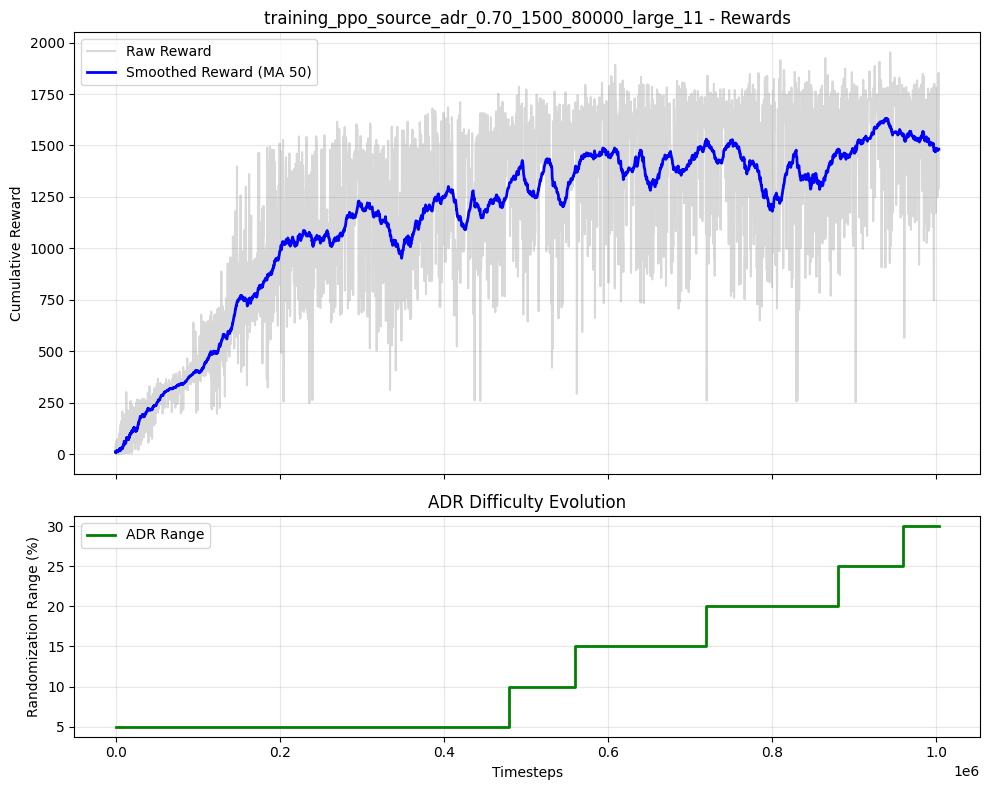

In [2]:
import importlib
import grid_search_utils

# Forza il ricaricamento del modulo modificato
importlib.reload(grid_search_utils)

from grid_search_utils import ADRGridSearch

# Definizione dei range: [start, end, step]
OBJ_ADR_GRID = [0.3, 0.7, 0.2]      # Test 0.3, 0.5, 0.7
REWARD_TH_GRID = [1200, 1500, 300]  # Test 1200, 1500, 1800
CHECK_FREQ_GRID = [40000, 80000, 40000] # Test 40k, 80k
ARCHITECTURES = ["medium", "large"]

grid = ADRGridSearch(
    train_env_id="CustomHopper-source-v0",
    test_env_id="CustomHopper-target-v0",
    obj_adr_range=OBJ_ADR_GRID,
    reward_threshold_range=REWARD_TH_GRID,
    check_freq_range=CHECK_FREQ_GRID,
    seed=SEED,
    timesteps=TIMESTEPS,
    architectures=ARCHITECTURES,
)


grid.run_search()